## Assignment: Image recognition
- Alumno 1:
- Alumno 2:
- Alumno 3:

The goals of the assignment are:
* Develop proficiency in using Tensorflow/Keras for training Neural Nets (NNs).
* Put into practice the acquired knowledge to optimize the parameters and architecture of a feedforward Neural Net (ffNN), in the context of an image recognition problem.
* Put into practice NNs specially conceived for analysing images. Design and optimize the parameters of a Convolutional Neural Net (CNN) to deal with previous task.
* Train popular architectures from scratch (e.g., GoogLeNet, VGG, ResNet, ...), and compare the results with the ones provided by their pre-trained versions using transfer learning.

Follow the link below to download the classification data set  “xview_recognition”: [https://drive.upm.es/s/4oNHlRFEd71HXp4](https://drive.upm.es/s/4oNHlRFEd71HXp4)

In [21]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()

if "GPU" not in device_name:
    print("GPU device not found")
    
print('Found GPU at: {}'.format(device_name))

print("GPU", "available (YESS!!!!)" if tf.config.list_physical_devices("GPU") else "not available :(")

Found GPU at: /device:GPU:0
GPU available (YESS!!!!)


2023-11-15 09:27:07.416443: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-15 09:27:07.417240: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-15 09:27:07.417941: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-15 09:27:07.733088: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-15 09:27:07.733116: I tensorflow/core/co

In [22]:
import uuid
import numpy as np

class GenericObject:
    """
    Generic object data.
    """
    def __init__(self):
        self.id = uuid.uuid4()
        self.bb = (-1, -1, -1, -1)
        self.category= -1
        self.score = -1

class GenericImage:
    """
    Generic image data.
    """
    def __init__(self, filename):
        self.filename = filename
        self.tile = np.array([-1, -1, -1, -1])  # (pt_x, pt_y, pt_x+width, pt_y+height)
        self.objects = list([])

    def add_object(self, obj: GenericObject):
        self.objects.append(obj)

In [23]:
categories = {0: 'Cargo plane', 1: 'Helicopter', 2: 'Small car', 3: 'Bus', 4: 'Truck', 5: 'Motorboat', 6: 'Fishing vessel', 7: 'Dump truck', 8: 'Excavator', 9: 'Building', 10: 'Storage tank', 11: 'Shipping container'}

In [24]:
import warnings
import rasterio
import numpy as np


def load_geoimage(filename):
    warnings.filterwarnings('ignore', category=rasterio.errors.NotGeoreferencedWarning)
    src_raster = rasterio.open(filename, 'r')
    # RasterIO to OpenCV (see inconsistencies between libjpeg and libjpeg-turbo)
    input_type = src_raster.profile['dtype']
    input_channels = src_raster.count
    img = np.zeros((src_raster.height, src_raster.width, src_raster.count), dtype=input_type)
    for band in range(input_channels):
        img[:, :, band] = src_raster.read(band+1)
    return img

In [25]:
import matplotlib.pyplot as plt
import numpy as np

def draw_confusion_matrix(cm, categories):
    # Draw confusion matrix
    fig = plt.figure(figsize=[6.4*pow(len(categories), 0.5), 4.8*pow(len(categories), 0.5)])
    ax = fig.add_subplot(111)
    cm = cm.astype('float') / np.maximum(cm.sum(axis=1)[:, np.newaxis], np.finfo(np.float64).eps)
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.get_cmap('Blues'))
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), xticklabels=list(categories.values()), yticklabels=list(categories.values()), ylabel='Annotation', xlabel='Prediction')
    # Rotate the tick labels and set their alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    # Loop over data dimensions and create text annotations
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], '.2f'), ha="center", va="center", color="white" if cm[i, j] > thresh else "black", fontsize=int(20-pow(len(categories), 0.5)))
    fig.tight_layout()
    plt.show(fig)

#### Training
Design and train a ffNN to deal with the “xview_recognition” classification task.

In [26]:
import json

# Load database
json_file = 'xview_ann_train.json'
with open(json_file) as ifs:
    json_data = json.load(ifs)
ifs.close()

In [27]:
import numpy as np

counts = dict.fromkeys(categories.values(), 0)
anns = []
for json_img, json_ann in zip(json_data['images'].values(), json_data['annotations'].values()):
    image = GenericImage(json_img['filename'])
    image.tile = np.array([0, 0, json_img['width'], json_img['height']])
    obj = GenericObject()
    obj.bb = (int(json_ann['bbox'][0]), int(json_ann['bbox'][1]), int(json_ann['bbox'][2]), int(json_ann['bbox'][3]))
    obj.category = json_ann['category_id']
    # Resampling strategy to reduce training time
    counts[obj.category] += 1
    image.add_object(obj)
    anns.append(image)
print(counts)

{'Cargo plane': 635, 'Helicopter': 70, 'Small car': 4290, 'Bus': 2155, 'Truck': 2746, 'Motorboat': 1069, 'Fishing vessel': 706, 'Dump truck': 1236, 'Excavator': 789, 'Building': 4689, 'Storage tank': 1469, 'Shipping container': 1523}


In [28]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_generator_minority = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        brightness_range=[0.4,1.5]
    )

data_generator_majority = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest',
        brightness_range=[0.6,1.3]
    )

minority_threshold = np.percentile(list(counts.values()), 25)

def is_minority_class(category):
    return counts[category] < minority_threshold

def generator_images(objs, batch_size, do_shuffle=False, is_data_augmentation=False):

    while True:
        if do_shuffle:
            np.random.shuffle(objs)
        groups = [objs[i:i+batch_size] for i in range(0, len(objs), batch_size)]
        for group in groups:
            images, labels = [], []
            for (filename, obj) in group:
                # Load image
                images.append(load_geoimage(filename))
                probabilities = np.zeros(len(categories))
                probabilities[list(categories.values()).index(obj.category)] = 1
                labels.append(probabilities)
            images = np.array(images).astype(np.float32)
            labels = np.array(labels).astype(np.float32)
            # Decidir qué data generator usar basado en la clase de la imagen
            if is_data_augmentation:
                for i, (filename, obj) in enumerate(group):
                    current_generator = data_generator_minority if is_minority_class(obj.category) else data_generator_majority
                    augmented_images, augmented_labels = next(current_generator.flow(np.expand_dims(images[i], 0), 
                                                                                    np.expand_dims(labels[i], 0), 
                                                                                    batch_size=batch_size))
                    images[i] = augmented_images[0]
                    labels[i] = augmented_labels[0]

            yield images, labels

In [29]:
from sklearn.model_selection import train_test_split

anns_train, anns_valid = train_test_split(anns, test_size=0.1, random_state=1, shuffle=True)

In [30]:
from keras.layers import Input, Dense, Dropout, BatchNormalization, Conv2D, ZeroPadding2D, add, MaxPooling2D, Flatten
from keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50

def Conv2d_BN(x, nb_filter, kernel_size, strides=(1, 1), padding='same', name=None):
    if name is not None:
        bn_name = name + '_bn'
        conv_name = name + '_conv'
    else:
        bn_name = None
        conv_name = None

    x = Conv2D(nb_filter, kernel_size, padding=padding, strides=strides, activation='relu', name=conv_name)(x)
    x = BatchNormalization(axis=3, name=bn_name)(x)
    return x


def identity_Block(inpt, nb_filter, kernel_size, strides=(1, 1), with_conv_shortcut=False):
    x = Conv2d_BN(inpt, nb_filter=nb_filter, kernel_size=kernel_size, strides=strides, padding='same')
    x = Conv2d_BN(x, nb_filter=nb_filter, kernel_size=kernel_size, padding='same')
    if with_conv_shortcut:
        shortcut = Conv2d_BN(inpt, nb_filter=nb_filter, strides=strides, kernel_size=kernel_size)
        x = add([x, shortcut])
        return x
    else:
        x = add([x, inpt])
        return x

def bottleneck_Block(inpt,nb_filters,strides=(1,1),with_conv_shortcut=False):
    k1,k2,k3=nb_filters
    x = Conv2d_BN(inpt, nb_filter=k1, kernel_size=1, strides=strides, padding='same')
    x = Conv2d_BN(x, nb_filter=k2, kernel_size=3, padding='same')
    x = Conv2d_BN(x, nb_filter=k3, kernel_size=1, padding='same')
    if with_conv_shortcut:
        shortcut = Conv2d_BN(inpt, nb_filter=k3, strides=strides, kernel_size=1)
        x = add([x, shortcut])
        return x
    else:
        x = add([x, inpt])
        return x

def resnet_50(width,height,channel,classes):
    with tf.device('/gpu:0'):
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(width, height, channel))

        for layer in base_model.layers:
            layer.trainable = False

        x = Flatten()(base_model.output)
        x = Dense(100,activation='relu')(x)
        x = Dropout(0.1)(x)
        predictions = Dense(classes, activation='softmax')(x)

        model = Model(inputs=base_model.input, outputs=predictions)

        return model

In [31]:
model = resnet_50(224,224,3,12)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [32]:
from keras.optimizers import Adam, SGD, RMSprop

# Learning rate is changed to 0.001
opt = Adam(learning_rate=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-8, amsgrad=True, clipnorm=1.0, clipvalue=0.5)
# opt = SGD(learning_rate=1e-3, momentum=0.9, clipnorm=1.0, clipvalue=0.5)
# opt = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [33]:
from keras.callbacks import TerminateOnNaN, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from time import time

# Callbacks
model_checkpoint = ModelCheckpoint('model.ckpt', monitor='val_accuracy', verbose=1, save_best_only=True)
terminate = TerminateOnNaN()

reduce_lr = ReduceLROnPlateau('accuracy', factor=0.5, patience=0.05, verbose=1, min_lr=0.00001)
early_stop = EarlyStopping('val_accuracy', patience=0.001, verbose=1, mode='auto')
tensorboard = TensorBoard(log_dir= 'logs_tl/{}'.format(time()), histogram_freq=1)
callbacks = [tensorboard, reduce_lr, model_checkpoint]

In [34]:
# Generate the list of objects from annotations
objs_train = [(ann.filename, obj) for ann in anns_train for obj in ann.objects]
objs_valid = [(ann.filename, obj) for ann in anns_valid for obj in ann.objects]
# Generators
batch_size = 128
train_generator = generator_images(objs_train, batch_size, do_shuffle=True, is_data_augmentation=False)
valid_generator = generator_images(objs_valid, batch_size, do_shuffle=False)

In [35]:
import math
import numpy as np
print('Training model')
epochs = 2
train_steps = math.ceil(len(objs_train)/batch_size)
valid_steps = math.ceil(len(objs_valid)/batch_size)
h = model.fit(train_generator, steps_per_epoch=train_steps, validation_data=valid_generator, validation_steps=valid_steps, epochs=epochs, callbacks=callbacks, verbose=2)
model.save('model.keras')

Training model
Epoch 1/2


2023-11-15 09:36:14.571233: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2408448000 exceeds 10% of free system memory.



Epoch 1: val_accuracy improved from -inf to 0.61880, saving model to model.ckpt
INFO:tensorflow:Assets written to: model.ckpt/assets


INFO:tensorflow:Assets written to: model.ckpt/assets


151/151 - 557s - loss: 2.4771 - accuracy: 0.5315 - val_loss: 1.2072 - val_accuracy: 0.6188 - lr: 0.0010 - 557s/epoch - 4s/step
Epoch 2/2


2023-11-15 09:45:36.526688: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2408448000 exceeds 10% of free system memory.



Epoch 2: val_accuracy improved from 0.61880 to 0.67633, saving model to model.ckpt
INFO:tensorflow:Assets written to: model.ckpt/assets


INFO:tensorflow:Assets written to: model.ckpt/assets


151/151 - 560s - loss: 1.0537 - accuracy: 0.6547 - val_loss: 1.0086 - val_accuracy: 0.6763 - lr: 0.0010 - 560s/epoch - 4s/step


#### Testing
Try to improve the results provided in the Moodle competition wiki.

In [36]:
import json

# Load database
json_file = 'xview_ann_test.json'
with open(json_file) as ifs:
    json_data = json.load(ifs)
ifs.close()

In [37]:
import numpy as np

anns = []
for json_img, json_ann in zip(json_data['images'].values(), json_data['annotations'].values()):
    image = GenericImage(json_img['filename'])
    image.tile = np.array([0, 0, json_img['width'], json_img['height']])
    obj = GenericObject()
    obj.bb = (int(json_ann['bbox'][0]), int(json_ann['bbox'][1]), int(json_ann['bbox'][2]), int(json_ann['bbox'][3]))
    obj.category = json_ann['category_id']
    image.add_object(obj)
    anns.append(image)

In [38]:
import numpy as np

from keras.models import load_model
# model.load_weights('model.hdf5', by_name=True)
# model = load_model('model.keras')
y_true, y_pred = [], []
for ann in anns:
    # Load image
    image = load_geoimage(ann.filename)
    for obj_pred in ann.objects:
        # Generate prediction
        warped_image = np.expand_dims(image, 0)
        predictions = model.predict(warped_image)
        # Save prediction
        pred_category = list(categories.values())[np.argmax(predictions)]
        pred_score = np.max(predictions)
        y_true.append(obj_pred.category)
        y_pred.append(pred_category)

1/1 [==============================] - 0s 26ms/step


/tmp/ipykernel_2012/956665539.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.get_cmap('Blues'))


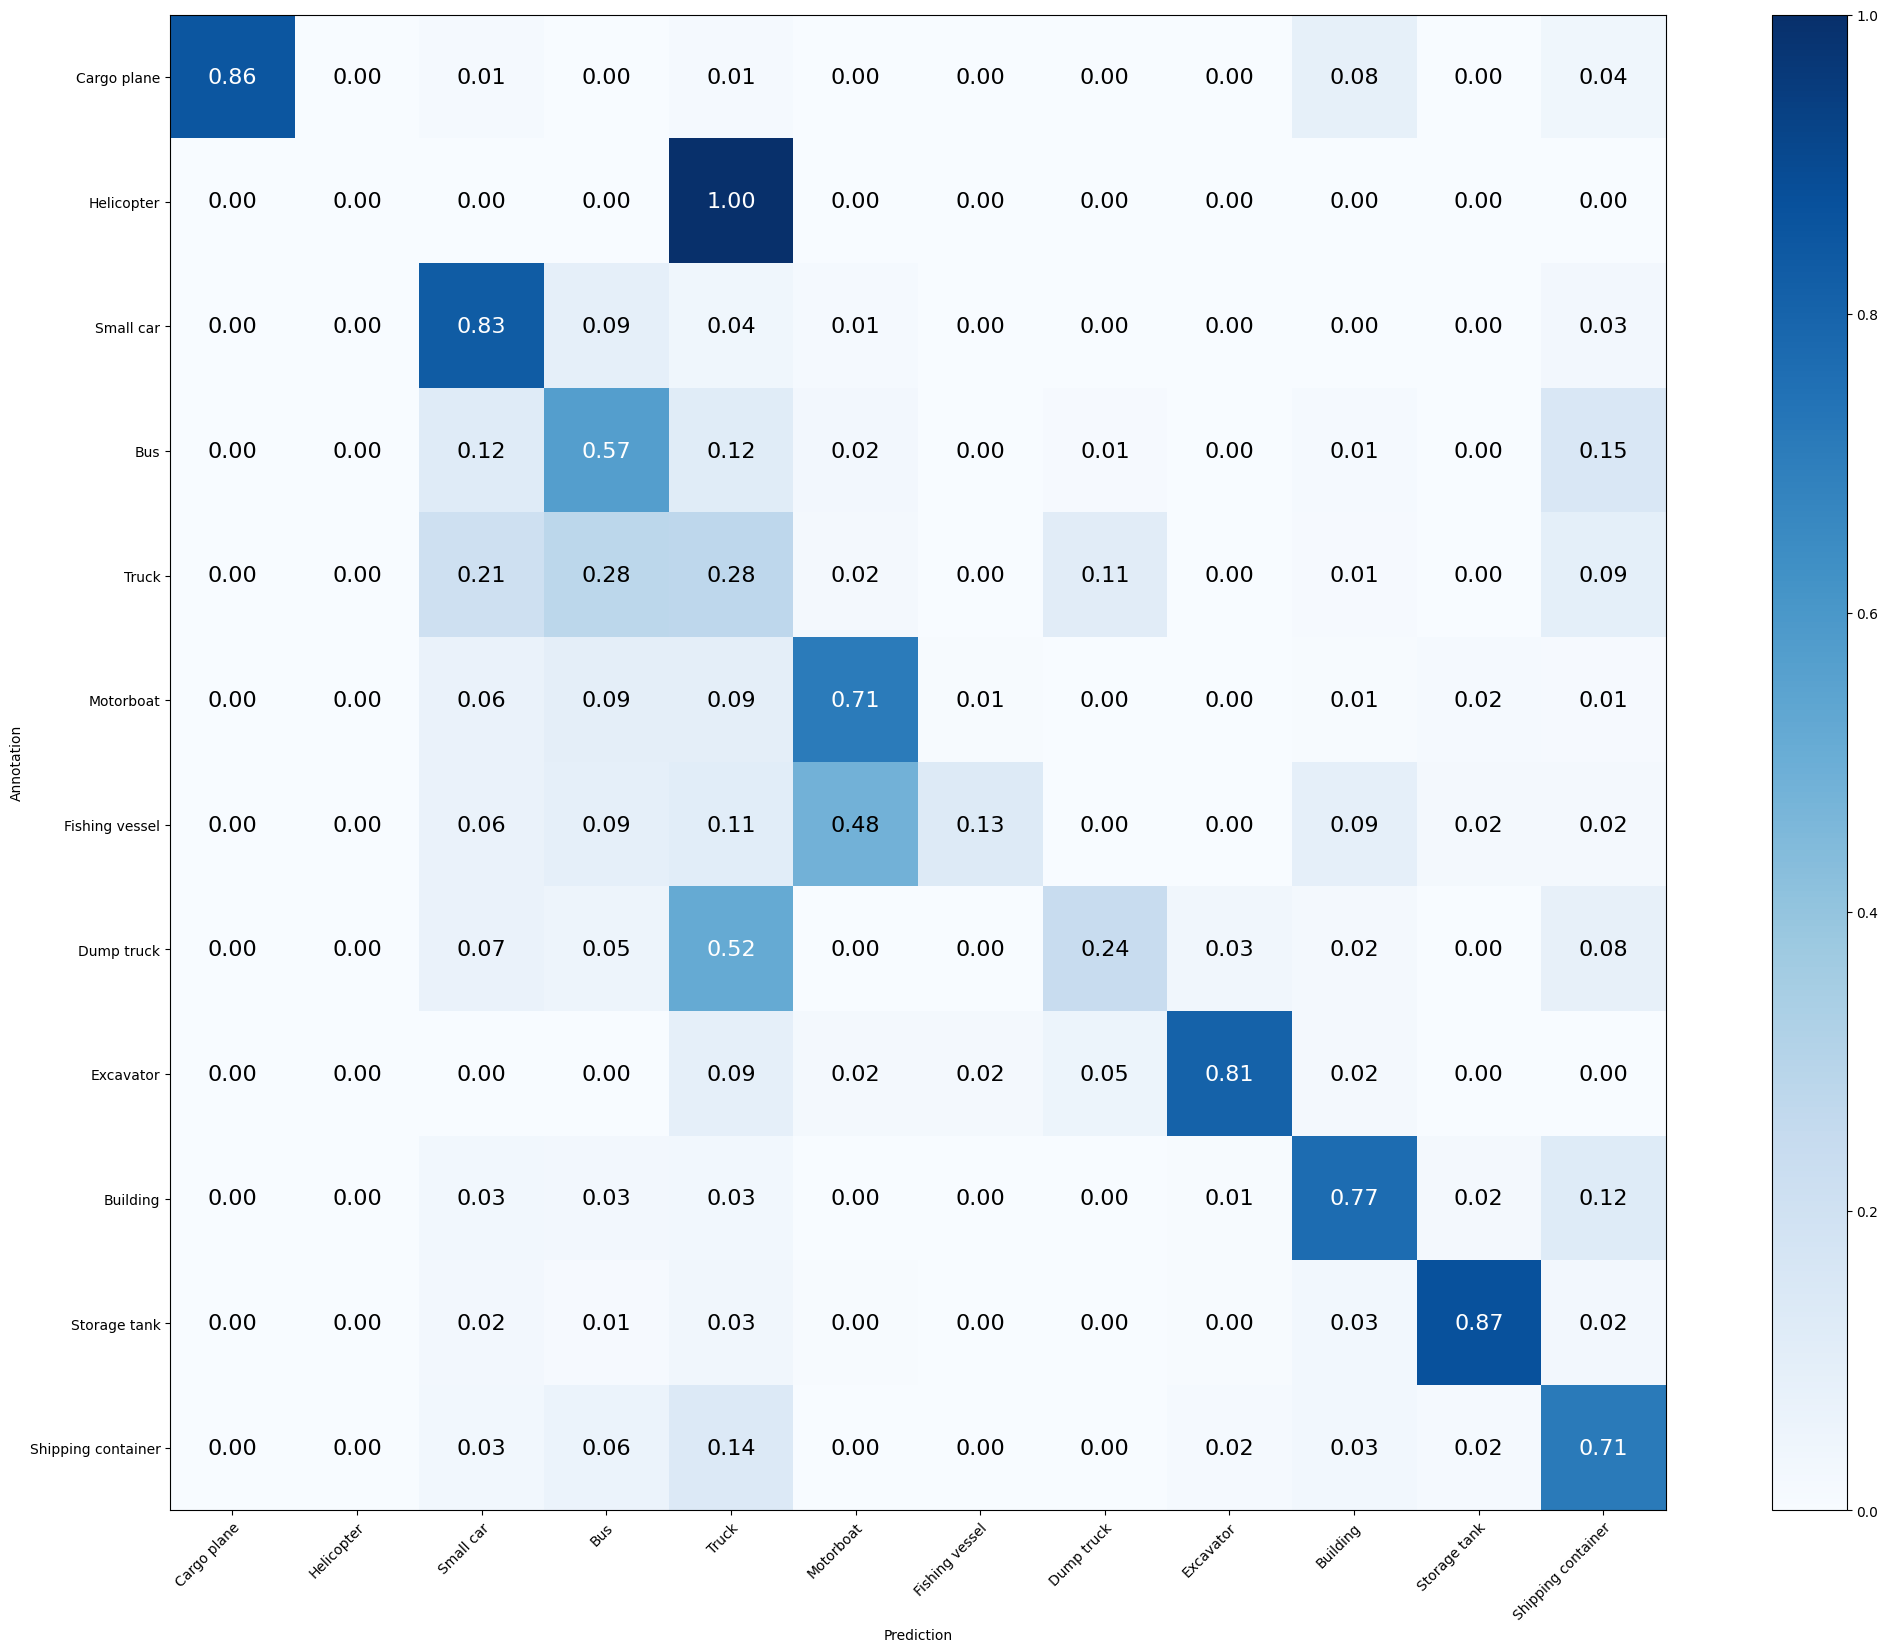

In [39]:
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=list(categories.values()))
draw_confusion_matrix(cm, categories)

In [40]:
import numpy as np

# Compute the accuracy
correct_samples_class = np.diag(cm).astype(float)
total_samples_class = np.sum(cm, axis=1).astype(float)
total_predicts_class = np.sum(cm, axis=0).astype(float)
print('Mean Accuracy: %.3f%%' % (np.sum(correct_samples_class) / np.sum(total_samples_class) * 100))
acc = correct_samples_class / np.maximum(total_samples_class, np.finfo(np.float64).eps)
print('Mean Recall: %.3f%%' % (acc.mean() * 100))
acc = correct_samples_class / np.maximum(total_predicts_class, np.finfo(np.float64).eps)
print('Mean Precision: %.3f%%' % (acc.mean() * 100))
for idx in range(len(categories)):
    # True/False Positives (TP/FP) refer to the number of predicted positives that were correct/incorrect.
    # True/False Negatives (TN/FN) refer to the number of predicted negatives that were correct/incorrect.
    tp = cm[idx, idx]
    fp = sum(cm[:, idx]) - tp
    fn = sum(cm[idx, :]) - tp
    tn = sum(np.delete(sum(cm) - cm[idx, :], idx))
    # True Positive Rate: proportion of real positive cases that were correctly predicted as positive.
    recall = tp / np.maximum(tp+fn, np.finfo(np.float64).eps)
    # Precision: proportion of predicted positive cases that were truly real positives.
    precision = tp / np.maximum(tp+fp, np.finfo(np.float64).eps)
    # True Negative Rate: proportion of real negative cases that were correctly predicted as negative.
    specificity = tn / np.maximum(tn+fp, np.finfo(np.float64).eps)
    # Dice coefficient refers to two times the intersection of two sets divided by the sum of their areas.
    # Dice = 2 |A∩B| / (|A|+|B|) = 2 TP / (2 TP + FP + FN)
    f1_score = 2 * ((precision * recall) / np.maximum(precision+recall, np.finfo(np.float64).eps))
    print('> %s: Recall: %.3f%% Precision: %.3f%% Specificity: %.3f%% Dice: %.3f%%' % (list(categories.values())[idx], recall*100, precision*100, specificity*100, f1_score*100))

Mean Accuracy: 66.072%
Mean Recall: 56.425%
Mean Precision: 60.783%
> Cargo plane: Recall: 85.542% Precision: 100.000% Specificity: 100.000% Dice: 92.208%
> Helicopter: Recall: 0.000% Precision: 0.000% Specificity: 100.000% Dice: 0.000%
> Small car: Recall: 83.162% Precision: 72.064% Specificity: 92.691% Dice: 77.216%
> Bus: Recall: 57.025% Precision: 40.950% Specificity: 91.684% Dice: 47.668%
> Truck: Recall: 27.541% Precision: 30.108% Specificity: 91.631% Dice: 28.767%
> Motorboat: Recall: 71.066% Precision: 80.692% Specificity: 97.010% Dice: 75.574%
> Fishing vessel: Recall: 12.903% Precision: 75.000% Specificity: 99.843% Dice: 22.018%
> Dump truck: Recall: 23.770% Precision: 42.647% Specificity: 98.448% Dice: 30.526%
> Excavator: Recall: 80.702% Precision: 82.143% Specificity: 99.612% Dice: 81.416%
> Building: Recall: 76.937% Precision: 92.257% Specificity: 98.328% Dice: 83.903%
> Storage tank: Recall: 87.243% Precision: 91.775% Specificity: 99.206% Dice: 89.451%
> Shipping contain

#### Report

You must prepare a report (PDF) describing:
* The problems and data sets (briefly).
* The process that you have followed to reach your solution for the “xview_recognition” benchmark, including your intermediate results. You must discuss and compare these results properly.
* Final network architectures, including optimization algorithms, regularization methods (dropout, data augmentation, etc.), number of layers/parameters, and performance obtained with your model on the train/valid/test data sets, including the plots of the evolution of losses and accuracy.
* It would also be very valuable your feedback on the use of “Cesvima” or “Google Colab" services.

In the submission via Moodle, attach your Python (.py) or Jupyter Notebook (.ipynb) source file, including in the report all results of computations attached to the code that generated them.

The assignment must be done in groups of 3 students.